<a href="https://colab.research.google.com/github/chrischo11/TimeSeriesAnalysis/blob/main/lobster_order_forecast_Chris_Cho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import scipy as sc
import statsmodels.formula.api as smf
import datetime as dt
import pandas_datareader as pdr
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, Holt
from sklearn.ensemble import RandomForestRegressor


c:\Users\HOME\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!


In [ ]:
lob = pd.read_csv('https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/ExtraCredit3.csv')


In [ ]:
lob['Date'] = lob['Date'] + '-2022'
lob['Date'] = pd.to_datetime(lob['Date'])

In [ ]:
lob['DOW'] = lob['Date'].dt.dayofweek
lob['DOW'] = lob['DOW'].astype(str)

In [ ]:
# check the email effect weeks
lob.loc[7:13, 'Email'] = 1
lob.loc[14:20, 'Email'] = 1
lob.loc[28:34, 'Email'] = 1
lob.loc[35:41, 'Email'] = 1
lob.loc[49:55, 'Email'] = 1
lob.loc[56:61, 'Email'] = 1

In [ ]:
lob.head()

,Date,Email,Orders,Shipments,NewCustomers,RepeatOrders,DOW
0,2022-07-01,0,2258.0,3364.0,659.0,1599.0,4
1,2022-07-02,0,1594.0,3201.0,506.0,1088.0,5
2,2022-07-03,0,1078.0,0.0,333.0,745.0,6
3,2022-07-04,0,605.0,0.0,213.0,392.0,0
4,2022-07-05,0,843.0,1364.0,286.0,557.0,1


When there is email promotion, Orders increased in weekly basis. <br>
Thus, I will calculate the effect of email promotion by comparing the average of orders with or with our email promotion. <br>
After that, I will remove the email effect from orders and build a model to fit the adjusted orders.

### RepeatOrders

In [ ]:
lob.loc[lob['Email']==1, 'RepeatOrders'].mean() / lob['RepeatOrders'].mean()
# During email weeks, repeat orders increase about 25.8%

1.258860946074652

In [ ]:
lob.loc[lob['Email']==0, 'RepeatOrders'].mean() / lob['RepeatOrders'].mean() 
# During no email weeks, repeat orders decrease about 31.4%

0.6856688511950656

In [ ]:
# Adjusted Repeat orders
lob.loc[lob['Email']==1, 'Adjusted RepeatOrders'] = round(lob['RepeatOrders'] / 1.25886, 0)
lob.loc[lob['Email']==0, 'Adjusted RepeatOrders'] = round(lob['RepeatOrders'] / 0.68567, 0)

There is apparent 7 days seasonality and slight upward trend in the orders. <Br>
So, I will use the exponential smoothing model to fit and predict the future orders.

In [ ]:
# Build a model to predict the Adjusted Repeat order : Smoothing model (trend + 7 days seasonality)

M = ExponentialSmoothing(lob.loc[lob['Date']<='2022-07-31', 'Adjusted RepeatOrders'], trend='add', seasonal='add', seasonal_periods=7, initialization_method="estimated").fit()


In [ ]:
lob.loc[lob['Date']<='2022-07-31', 'AdjRepeat_fitted'] = M.fittedvalues

In [ ]:
# Forecast for the August Adjusted repeat orders
lob.loc[len(lob)-31:, 'AdjRepeat_forecast'] = M.forecast(31)


According to the email promotion plan, I will apply the promotion effect on the August order prediction.

In [ ]:
# Email effect applied
lob.loc[lob['Email']==1, 'Repeat_fitted'] = np.round(lob['AdjRepeat_fitted'] * 1.25886, 0)
lob.loc[lob['Email']==0, 'Repeat_fitted'] = np.round(lob['AdjRepeat_fitted'] * 0.68567, 0)
lob.loc[lob['Email']==1, 'Repeat_forecast'] = np.round(lob['AdjRepeat_forecast'] * 1.25886, 0)
lob.loc[lob['Email']==0, 'Repeat_forecast'] = np.round(lob['AdjRepeat_forecast'] * 0.68567, 0)

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


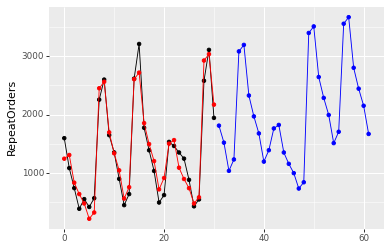

<ggplot: (178515754454)>

In [ ]:
# plot data and overlay the fitted and forecasted values

(
   ggplot(lob,aes(lob.index,'RepeatOrders')) + geom_point(aes()) + geom_line() + 
   geom_point(aes(lob.index,'Repeat_fitted'),color='red') + geom_line(aes(lob.index,'Repeat_fitted'),color='red') +
   geom_point(aes(lob.index,'Repeat_forecast'),color='blue') + geom_line(aes(lob.index,'Repeat_forecast'),color='blue') +
   theme(figure_size=(14,5)) 
) 


### NewCustomers

In [ ]:
lob.loc[lob['Email']==1, 'NewCustomers'].mean() / lob['NewCustomers'].mean()

1.1602188907871105

In [ ]:
lob.loc[lob['Email']==0, 'NewCustomers'].mean() / lob['NewCustomers'].mean() 
# During no email weeks, repeat orders decrease about 31.4%

0.8054484897585087

In [ ]:
# Adjusted NewCustomers
lob.loc[lob['Email']==1, 'Adjusted NewCustomers'] = round(lob['NewCustomers'] / 1.16022, 0)
lob.loc[lob['Email']==0, 'Adjusted NewCustomers'] = round(lob['NewCustomers'] / 0.80545, 0)

In [ ]:
# Build a model to predict the Adjusted NewCustomers : Smoothing model (trend + 7 days seasonality)

M1 = ExponentialSmoothing(lob.loc[lob['Date']<='2022-07-31', 'Adjusted NewCustomers'], trend='add', seasonal='add', seasonal_periods=7, initialization_method="estimated").fit()


In [ ]:
lob.loc[lob['Date']<='2022-07-31', 'AdjNewCustomers_fitted'] = M1.fittedvalues

In [ ]:
# Forecast for the August Adjusted New Customer orders
lob.loc[len(lob)-31:, 'AdjNewCustomers_forecast'] = M1.forecast(31)

In [ ]:
# Email effect applied

lob.loc[lob['Email']==1, 'NewCustomers_fitted'] = np.round(lob['AdjNewCustomers_fitted'] * 1.16022, 0)
lob.loc[lob['Email']==0, 'NewCustomers_fitted'] = np.round(lob['AdjNewCustomers_fitted'] * 0.80545, 0)
lob.loc[lob['Email']==1, 'NewCustomers_forecast'] = np.round(lob['AdjNewCustomers_forecast'] * 1.16022, 0)
lob.loc[lob['Email']==0, 'NewCustomers_forecast'] = np.round(lob['AdjNewCustomers_forecast'] * 0.80545, 0)

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


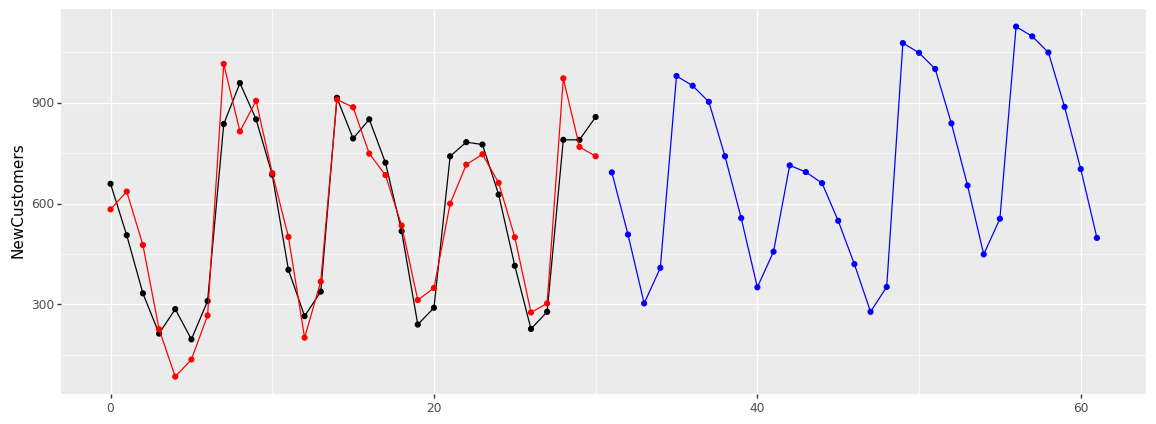

<ggplot: (178515588958)>

In [ ]:
# plot data and overlay the fitted and forecasted values
(
   ggplot(lob,aes(lob.index,'NewCustomers')) + geom_point(aes()) + geom_line() + 
   geom_point(aes(lob.index,'NewCustomers_fitted'),color='red') + geom_line(aes(lob.index,'NewCustomers_fitted'),color='red') +
   geom_point(aes(lob.index,'NewCustomers_forecast'),color='blue') + geom_line(aes(lob.index,'NewCustomers_forecast'),color='blue') +
   theme(figure_size=(14,5)) 
) 


### Daily Orders

Daily Orders = New Customers + RepeatOrders <br>
Thus, Daily Orders_forecast = NewCustomers_forecast + Repeat_forecast



In [ ]:
lob['Orders_fitted'] = lob['NewCustomers_fitted'] + lob['Repeat_fitted']
lob['Orders_forecast'] = lob['NewCustomers_forecast'] + lob['Repeat_forecast']

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


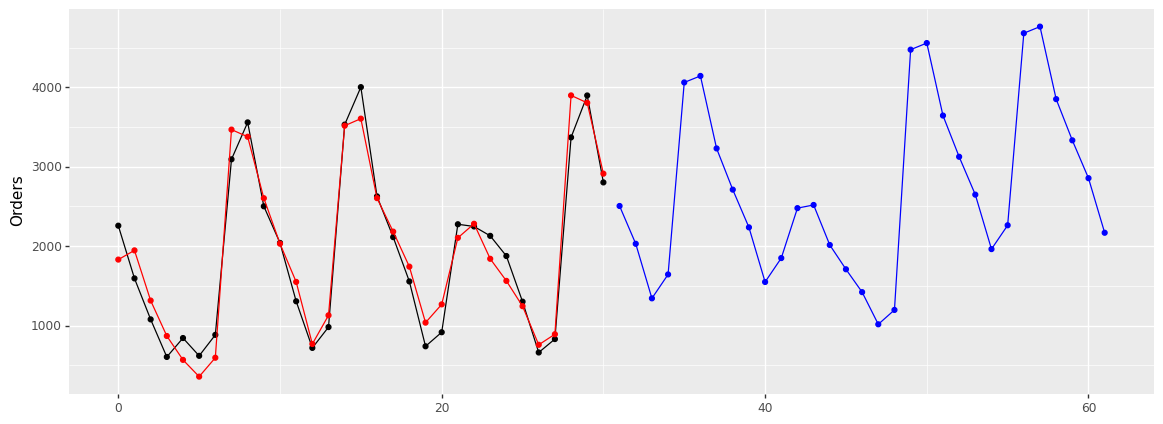

<ggplot: (178515915168)>

In [ ]:
# Ploting the Orders, fitted, and forecasted Orders
(
   ggplot(lob,aes(lob.index,'Orders')) + geom_point() + geom_line() + 
   geom_point(aes(lob.index,'Orders_fitted'), color='red') + geom_line(aes(lob.index,'Orders_fitted'),color='red') + 
   geom_point(aes(lob.index,'Orders_forecast'), color='blue') + geom_line(aes(lob.index,'Orders_forecast'),color='blue') + 
   theme(figure_size=(14,5)) 
) 

### Shipments

Because Shipment is closely related to the daily order. <br>
I will make a random forest model by using daliy order as a independent variable and shipments as a dependent variable.

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


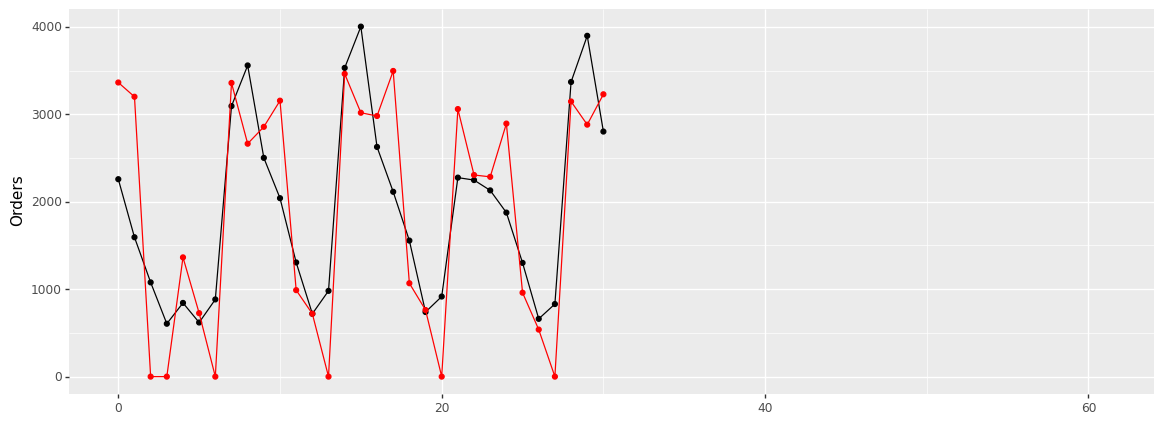

<ggplot: (178515958233)>

In [ ]:
# ploting Orders and Shipments
(
   ggplot(lob,aes(lob.index,'Orders')) + geom_point() + geom_line() + 
   geom_point(aes(lob.index,'Shipments'), color='red') + geom_line(aes(lob.index,'Shipments'),color='red') + 
   theme(figure_size=(14,5)) 
) 

In [ ]:
x_train, x_test = np.array(lob.loc[:30, 'Orders']), np.array(lob.loc[31:, 'Orders_forecast']) 
y_train, y_test = np.array(lob.loc[:30, 'Shipments']), np.array(lob.loc[31: 'Shipments'])

In [ ]:
# build a random forest model
M2 = RandomForestRegressor(n_estimators=100)

In [ ]:
M2.fit(x_train.reshape(-1,1), y_train.reshape(-1,1))

<ipython-input-28-5b8b01e379cf>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()

In [ ]:
lob.loc[:30, 'Shipment_fitted'] = M2.predict(np.array(lob.loc[:30,'Orders']).reshape(-1,1))

In [ ]:
lob.loc[31:, 'Shipment_predict'] = M2.predict(np.array(lob.loc[31:,'Orders_forecast']).reshape(-1,1))

c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\layer.py:412: PlotnineWarning: geom_point : Removed 31 rows containing missing values.
c:\Users\HOME\anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:75: PlotnineWarning: geom_path: Removed 31 rows containing missing values.


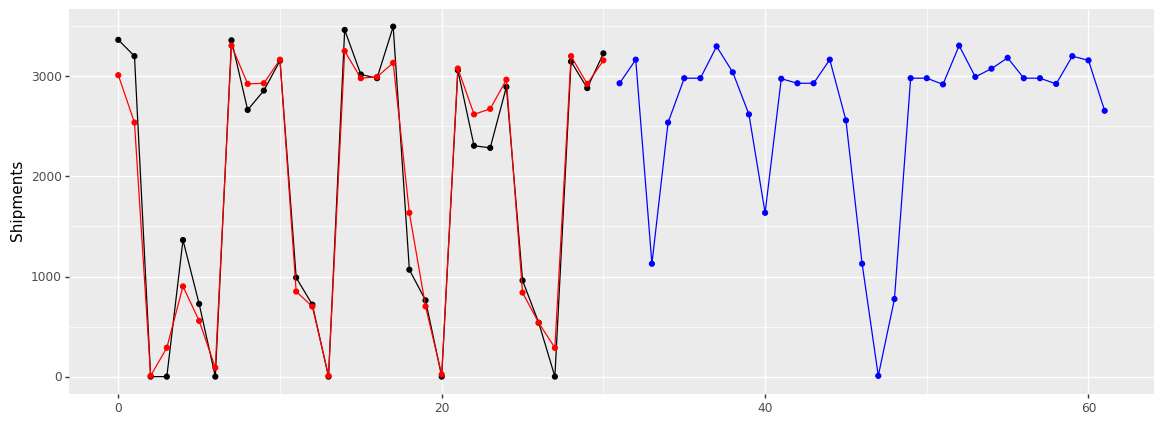

<ggplot: (178515922830)>

In [ ]:
# plot data and overlay the fitted values
(
   ggplot(lob,aes(lob.index,'Shipments')) + geom_point(aes()) + geom_line() + 
   geom_point(aes(lob.index,'Shipment_fitted'),color='red') + geom_line(aes(lob.index,'Shipment_fitted'),color='red') +
   geom_point(aes(lob.index,'Shipment_predict'),color='blue') + geom_line(aes(lob.index,'Shipment_predict'),color='blue') + 
   theme(figure_size=(14,5)) 
) 